In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
from typing import Callable, Mapping, Tuple, TypeVar, Set

In [3]:
from src.mdps.in_class_maze_runner import BasicMazeRunner
from src.mdps.grid_maze import RandomGridMaze
from src.value_iteration.value_iteration_methods import value_iteration
from src.value_iteration.core import get_greedy_policy

In [7]:
class_mr = BasicMazeRunner()
maze_runner_actions, maze_runner_transitions, maze_runner_rewards = class_mr.get_mdp()

pure vi {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0} 2
random k {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0} 2
[1.0, 0.0]
influence tree {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0} 2


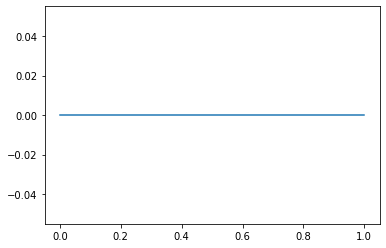

cyclic vi {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0} 2
random permut cyclic {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0} 2


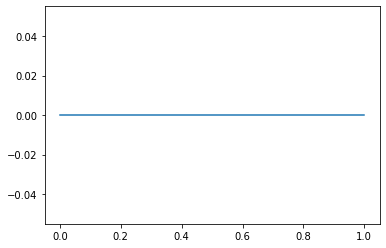

In [8]:
pure_vi, num_iter, _ = value_iteration(actions=maze_runner_actions, transitions=maze_runner_transitions, rewards=maze_runner_rewards,
               discount=0.9)
print('pure vi', pure_vi, num_iter)

random_k_vi, num_iter_random_k, rk_convergence = value_iteration(actions=maze_runner_actions, transitions=maze_runner_transitions, rewards=maze_runner_rewards,
               discount=0.9, vi_method='random-k', k=3, log_converence=True, gt_vf=pure_vi)
print('random k', random_k_vi, num_iter_random_k)
print(rk_convergence)


tree_vi, num_iter_tree, it_convergence = value_iteration(actions=maze_runner_actions, transitions=maze_runner_transitions, rewards=maze_runner_rewards,
               discount=0.9, vi_method='influence-tree', log_converence=True, gt_vf=pure_vi)
print('influence tree', tree_vi, num_iter_tree)
plt.plot(it_convergence)
plt.show()

cyclic_vi, num_iter_cyclic,cvi_convergence = value_iteration(actions=maze_runner_actions, transitions=maze_runner_transitions, rewards=maze_runner_rewards,
               discount=0.9, vi_method='cyclic-vi', log_converence=True, gt_vf=pure_vi)
print('cyclic vi', cyclic_vi, num_iter_cyclic)

rp_cyclic_vi, rp_num_iter_cyclic, c_vi_rp_convergence = value_iteration(actions=maze_runner_actions, transitions=maze_runner_transitions, rewards=maze_runner_rewards,
               discount=0.9, vi_method='cyclic-vi-rp', log_converence=True, gt_vf=pure_vi)
print('random permut cyclic', rp_cyclic_vi, rp_num_iter_cyclic)
plt.plot(c_vi_rp_convergence)
plt.show()


In [4]:
# maze = RandomGridMaze(4,4, 1, seed=0)
# maze_actions, maze_transitions, maze_rewards, terminal_maze_state = maze.get_mdp()

maze = RandomGridMaze(50,50, 1, seed=0)
maze_actions, maze_transitions, maze_rewards, terminal_maze_state = maze.get_mdp()


random k


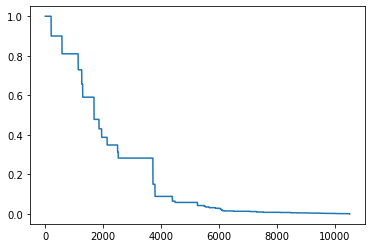


tree


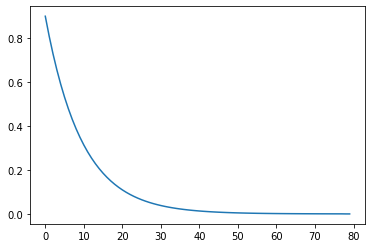


cyclic


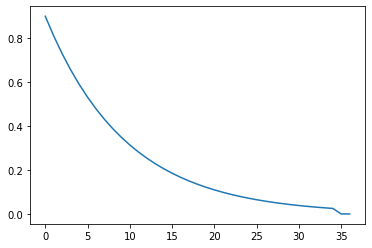


cyclic random permute


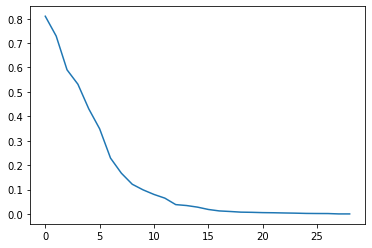

In [5]:
pure_vi, num_iter, _ = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               discount=0.9)
# print(pure_vi)
# print(num_iter)
policy_p_vi = get_greedy_policy(value_function=pure_vi, actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               terminal_states=set(terminal_maze_state), discount=0.9)
# print(policy_p_vi)
# print()

print('random k')
k_vi, k_num_iter, rk_convergence = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               discount=0.9, vi_method='random-k', k=10, log_converence=True, gt_vf=pure_vi)
# print(k_vi)
# print(k_num_iter)
policy_k_vi = get_greedy_policy(value_function=k_vi, actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               terminal_states=set(terminal_maze_state), discount=0.9)
# print(policy_k_vi)
plt.plot(rk_convergence)
plt.show()
print()


print('tree')
tree_vi, tree_num_iter, it_convergence = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               discount=0.9, vi_method='influence-tree', log_converence=True, gt_vf=pure_vi)
# print(tree_vi)
# print(tree_num_iter)
policy_tree_vi = get_greedy_policy(value_function=tree_vi, actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               terminal_states=set(terminal_maze_state), discount=0.9)
# print(policy_tree_vi)
plt.plot(it_convergence)
plt.show()
print()

print('cyclic')
cyclic_vi, cyclic_num_iter, cvi_convergence = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               discount=0.9, vi_method='cyclic-vi', log_converence=True, gt_vf=pure_vi)
# print(cyclic_vi)
# print(cyclic_num_iter)
policy_cyclic_vi = get_greedy_policy(value_function=cyclic_vi, actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               terminal_states=set(terminal_maze_state), discount=0.9)
# print(policy_cyclic_vi)
plt.plot(cvi_convergence)
plt.show()
print()

print('cyclic random permute')
rp_cyclic_vi, rp_cyclic_num_iter, c_vi_rp_convergence = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               discount=0.9, vi_method='cyclic-vi-rp', log_converence=True, gt_vf=pure_vi)
# print(rp_cyclic_vi)
# print(rp_cyclic_num_iter)
rp_policy_cyclic_vi = get_greedy_policy(value_function=rp_cyclic_vi, actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               terminal_states=set(terminal_maze_state), discount=0.9)
# print(rp_policy_cyclic_vi)
plt.plot(c_vi_rp_convergence)
plt.show()
print()